In [2]:
from stable_baselines3 import TD3
#from train import alg_name, env_config, env
#from train import final_model_name
from toy_models.envs.utils import minmax
import time
from scripts.q_integration import mc_partial_integration
from scripts.q_integration import mc_total_integration
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt

from tqdm import tqdm

## Load Model

In [4]:
model = TD3.load('./logs/test/final.zip')
critic = model.critic
actor = model.policy

## Total integration

In [5]:
integration = []
x = np.logspace(2, 5, num=100)
x = np.array([int(i) for i in x])
for i in x:
    integ = mc_total_integration(critic, n_points=i)
    integration.append(integ)
  


In [6]:
np.average([mc_total_integration(critic, n_points=int(6e4)) for i in range(10)])

11.710903229166666

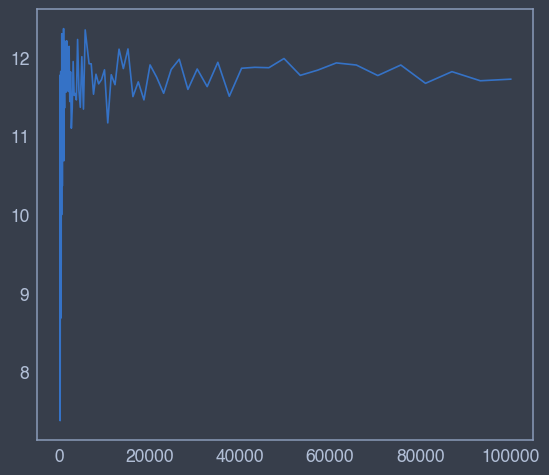

In [7]:
fig, ax = plt.subplots()
ax.plot(x,integration)
plt.show(fig)

## Partial integration

In [27]:
%time state, integ = mc_partial_integration(critic, n_points=int(1e5))

CPU times: user 2.14 s, sys: 561 ms, total: 2.7 s
Wall time: 514 ms


In [28]:
action = np.random.uniform(-1,1,size=(1,2))
%time action, integ = mc_partial_integration(critic, n_points=int(1e5), state=action)

CPU times: user 1.94 s, sys: 399 ms, total: 2.34 s
Wall time: 348 ms


In [8]:
n_samples = 1000
states = np.zeros((n_samples, 2))
integrated_q = np.zeros((n_samples, 1))

for i in tqdm(range(n_samples)):
    state, integ = mc_partial_integration(critic, n_points=int(1e4))
    states[i] = state
    integrated_q[i] = integ

100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.32it/s]


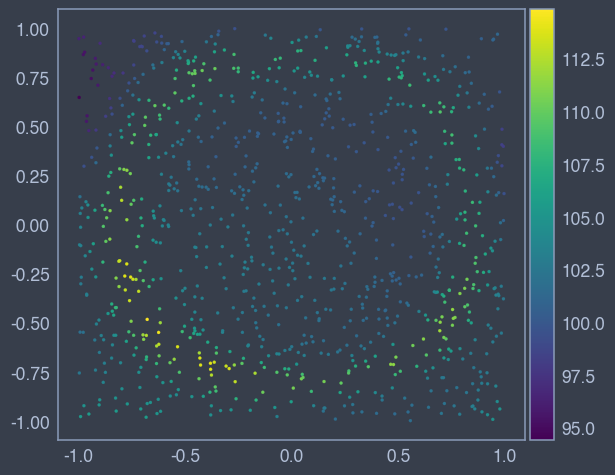

In [9]:

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.scatter(states[:,0], states[:,1], c=integrated_q, s=5)
fig.colorbar(im, cax=cax, orientation='vertical')


#### Integrating N best

In [11]:
from q_integration import mc_partial_integration_best

In [17]:
n_samples = 1000
states = np.zeros((n_samples, 2))
integrated_q = np.zeros((n_samples, 1))

for i in tqdm(range(n_samples)):
    state, integ = mc_partial_integration_best(critic, n_points=int(1e3), n_best=50)
    states[i] = state
    integrated_q[i] = integ

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 201.17it/s]


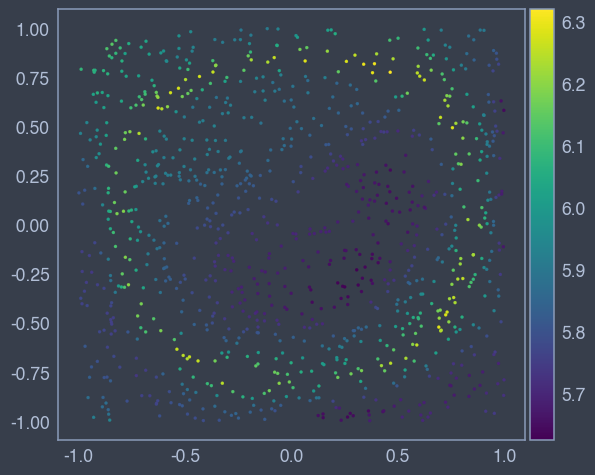

In [18]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.scatter(states[:,0], states[:,1], c=integrated_q, s=5)
fig.colorbar(im, cax=cax, orientation='vertical')


In [33]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process.kernels import Matern



In [34]:
kernel = ConstantKernel(0.1, (0.01, 1e4)) *RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel)

In [35]:
gp.fit(states, minmax(integrated_q, [integrated_q.min(), integrated_q.max()], [-0,1]))

GaussianProcessRegressor(kernel=0.316**2 * RBF(length_scale=1))

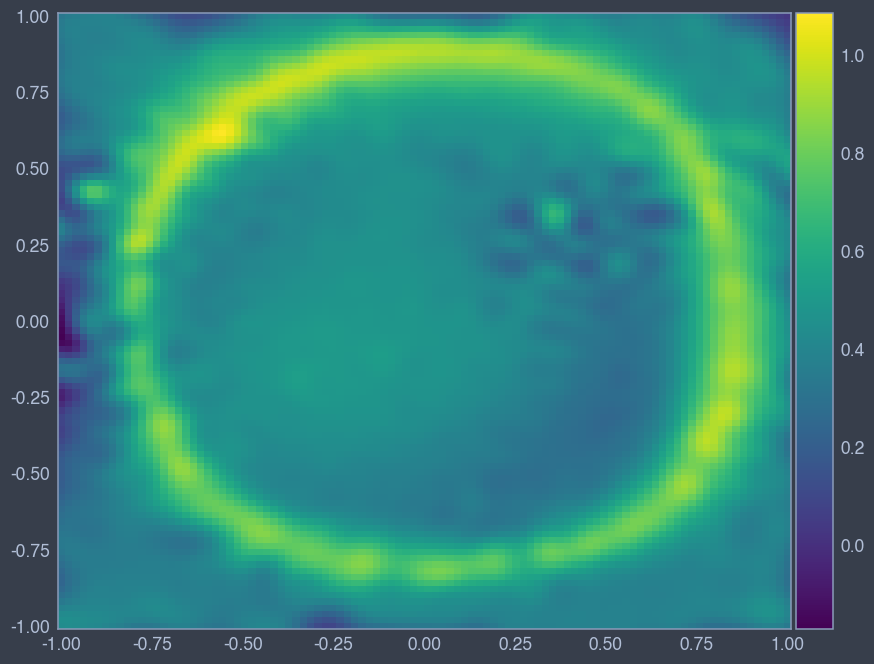

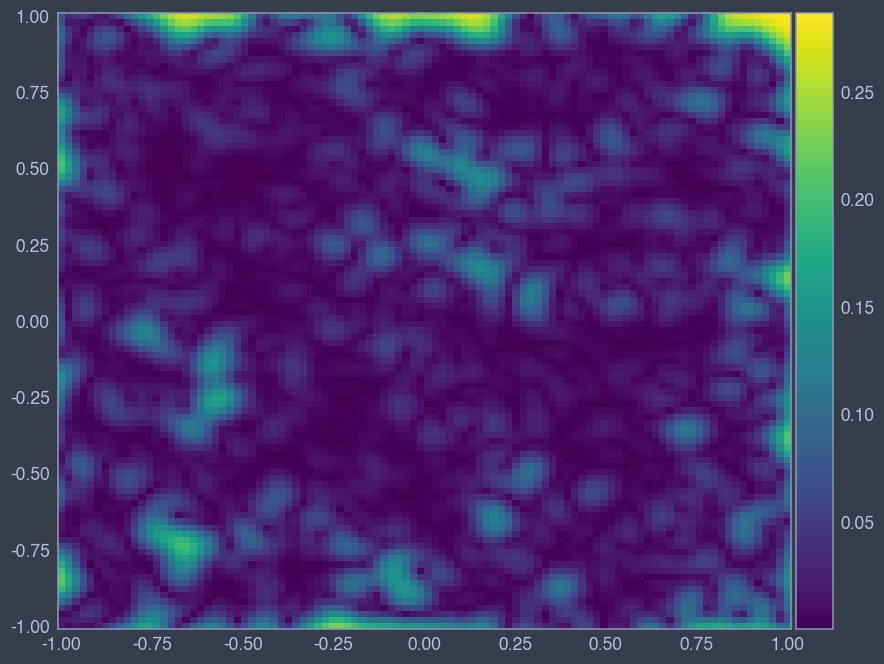

In [36]:
from itertools import product
res = 100
x1 = np.linspace(-1, 1,res) #p
x2 = np.linspace(-1, 1,res) #q
x = (np.array([x1, x2])).T
x1x2 = np.array(list(product(x1, x2)))
y_pred, MSE = gp.predict(x1x2, return_std=True)

X0p, X1p = x1x2[:,0].reshape(res,res), x1x2[:,1].reshape(res,res)
Zp = np.reshape(y_pred,(res,res))

# alternative way to generate equivalent X0p, X1p, Zp
# X0p, X1p = np.meshgrid(x1, x2)
# Zp = [gp.predict([(X0p[i, j], X1p[i, j]) for i in range(X0p.shape[0])]) for j in range(X0p.shape[1])]
# Zp = np.array(Zp).T

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.pcolormesh(X0p, X1p, Zp)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
Zp = np.reshape(MSE,(res,res))
im = ax.pcolormesh(X0p, X1p, Zp)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

#### Notes:

- can we do inportance sampling? 
- how can we use this?


In [46]:
gp.predict??

In [37]:
np.exp(2)

7.38905609893065